In [1]:
from bounter import bounter
from collections import Counter
import numpy as np
import time
import pickle
from scipy.sparse import dok_matrix, csr_matrix
import numpy as np

ModuleNotFoundError: No module named 'bounter'

In [ ]:
CORPUS_FILE = "data/text8"
MIN_COUNT = 1000
WINDOW = 10

In [ ]:
# This is a generator for producing words.
def read_words(f):
    while True:
        buf = f.read(10240)
        if not buf:
            break

        # make sure we end on a space (word boundary)
        while not str.isspace(buf[-1]):
            ch = f.read(1)
            if not ch:
                break
            buf += ch

        words = buf.split()
        for word in words:
            yield word
    yield '' #handle the scene that the file is empty

In [ ]:
# Reads vocab from corpus file, tallying counts. 
# only keep those that have count >= MIN_COUNT.
def read_vocab():
    with open(CORPUS_FILE, 'r') as f:
        vocab = bounter(size_mb=8192)
        i = 1
        
        for word in read_words(f):
            if i % 1000000 == 0:
                print("Words processed so far: {}".format(i), end="\r")
            i += 1
            vocab.increment(word, 1)
            
        print("\nTotal distinct: {}".format(len(list(vocab))))
        wordcounts = dict([(token, count) for token, count in vocab.items() if count >= MIN_COUNT])
        print("Truncated total number of words: = {}".format(len(wordcounts)))
        print("First 5: {}".format({k: wordcounts[k] for k in list(wordcounts)[:5]}))
    return wordcounts

start = time.time()
wordcounts = read_vocab()
end = time.time()
print("Time spent: {}".format(end-start))

# OUT_FILE = CORPUS_FILE + ".wordcounts.p"
# pickle.dump(wordcounts, open(OUT_FILE, "wb"))

In [ ]:
# build dicts to map from words to indices and indices to words.
idx2word = list(wordcounts.keys())
word2idx = {idx2word[i]: i for i in range(len(idx2word))}
# OUT_FILE = CORPUS_FILE + ".idx2word.p"
# pickle.dump(idx2word, open(OUT_FILE, "wb"))
# OUT_FILE = CORPUS_FILE + ".word2idx.p"
# pickle.dump(word2idx, open(OUT_FILE, "wb"))

In [ ]:
# sliding window co-occurences.
def get_co_counts():
    word_list = []
    co_counts = Counter()
    
    with open(CORPUS_FILE, 'r') as f:
        cnt = 1
        
        for word in read_words(f):
            if cnt % 100000 == 0:
                print("Words processed so far: {}".format(cnt), end="\r")
            cnt += 1
            if word not in word2idx:
                continue
            w2 = word
            if len(word_list) > WINDOW:
                word_list.pop(0)
            for w1 in word_list:
                co_counts.update([w1 + " " + w2])
                co_counts.update([w2 + " " + w1])
            word_list.append(w2)
    return co_counts

start = time.time()
co_counts = get_co_counts()
end = time.time()
print("time spent: {}".format(end-start))

In [ ]:
with open("data/text8.vocab.txt") as f:
    g = f.readlines()

word_dict = {}
for entry in g:
    w, c = entry.strip().split()
    word_dict[w] = int(c)
n = len(word_dict)


In [ ]:
co_counts.get("in the")

In [ ]:
counts = csr_matrix((n, n), dtype=np.int32)
tmp_counts = dok_matrix((n, n), dtype=np.int32)
update_threshold = 100000

import struct

i = 0
with open("data/text8.cooccurrence.bin", "rb") as f:
    while True:
        try:
            id1 = struct.unpack('i', f.read(4))[0]
            id2 = struct.unpack('i', f.read(4))[0]
            c = struct.unpack('d', f.read(8))[0]
            tmp_counts[id1-1, id2-1] = int(c)

            if i == update_threshold:
                counts = counts + tmp_counts.tocsr()
                tmp_counts = dok_matrix((n,n), dtype=np.int32)
                i = 0
        except:
            break
    counts = counts + tmp_counts.tocsr()
    
scipy.sparse.save_npz('data/text8.comat.npz')

In [ ]:
VOCAB_FILE = 'data/wikipedia.vocab.txt'
COOCCUR_FILE = 'data/wikipedia.cooccurrence.bin'
WORD2ID_FILE = 'data/wikipedia.word2id.p'
ID2WORD_FILE = 'data/wikipedia.id2word.p'
COMAT_FILE = 'data/wikipedia.comat.npz'

with open(VOCAB_FILE) as f:
    words = f.readlines()

n = len(words)

word2id = {}
id2word = []

id = 0
for entry in words:
    w, c = entry.strip().split()
    word2id[w] = id
    id2word.append(w)
    id += 1

print(word2id["the"])
print(id2word[0])

n

In [33]:
from scipy.sparse import load_npz
import struct
dat = load_npz("data/text8.comat.npz")

# Validate on text8.
with open("data/text8.cooccur.trunc.bin", "rb") as f:
    i = 0
    while True:
        try:
            id1 = struct.unpack('i', f.read(4))[0]
            id2 = struct.unpack('i', f.read(4))[0]
            c = struct.unpack('d', f.read(8))[0]
            i += 1
        except:
            break
        print(id1, id2, c)
        if i == 20:
            break
            
[(i, j) for i, j in zip(*dat.nonzero())]

1 1 0.013061916267597236
1 2 0.004373779852971567
1 3 0.002505432245857991
1 4 0.0015341652812451978
1 5 0.002337649691291817
1 6 0.0016618871490928196
1 7 0.001972773215866623
1 8 0.0009282296549733783
1 9 0.0008639011219721459
1 10 0.0007215763350763316
1 11 0.0011963622465672133
1 12 0.0007683835485617289
1 13 0.0004222801753965959
1 14 0.0006861916391319949
1 15 0.0006736046725265382
1 16 0.0003934746166660972
1 17 0.0004034197394567052
1 18 0.0007366559504602612
1 19 0.0007153756438084223
1 20 0.0006524953943310326


[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (0, 17),
 (0, 18),
 (0, 19),
 (0, 20),
 (0, 21),
 (0, 22),
 (0, 23),
 (0, 24),
 (0, 25),
 (0, 26),
 (0, 27),
 (0, 28),
 (0, 29),
 (0, 30),
 (0, 31),
 (0, 32),
 (0, 33),
 (0, 34),
 (0, 35),
 (0, 36),
 (0, 37),
 (0, 38),
 (0, 39),
 (0, 40),
 (0, 41),
 (0, 42),
 (0, 43),
 (0, 44),
 (0, 45),
 (0, 46),
 (0, 47),
 (0, 48),
 (0, 49),
 (0, 50),
 (0, 51),
 (0, 52),
 (0, 53),
 (0, 54),
 (0, 55),
 (0, 56),
 (0, 57),
 (0, 58),
 (0, 59),
 (0, 60),
 (0, 61),
 (0, 62),
 (0, 63),
 (0, 64),
 (0, 65),
 (0, 66),
 (0, 67),
 (0, 68),
 (0, 69),
 (0, 70),
 (0, 71),
 (0, 72),
 (0, 73),
 (0, 74),
 (0, 75),
 (0, 76),
 (0, 77),
 (0, 78),
 (0, 79),
 (0, 80),
 (0, 81),
 (0, 82),
 (0, 83),
 (0, 84),
 (0, 85),
 (0, 86),
 (0, 87),
 (0, 88),
 (0, 89),
 (0, 90),
 (0, 91),
 (0, 92),
 (0, 93),
 (0, 94),
 (0, 95),
 (0, 96),
 (0, 97),
 (0, 98),
 (0, 99),
 (0, 100),

In [29]:
VOCAB_TXT_FILE = "data/text8.vocab.txt"
# first we read vocab and write to a text file of the truncated vocab...
with open(VOCAB_TXT_FILE, 'r') as f:
    words = f.readlines()
    words = words[:NUM_WORDS]
    print(len(words))

3446


In [ ]:
dat2 = load_npz("data/wikipedia.comat.npz")

In [ ]:
dat2[0,9]

In [ ]:
# Validate on text8.
with open("data/wikipedia.cooccurrence.bin", "rb") as f:
    for i in range(10):
        id1 = struct.unpack('i', f.read(4))[0]
        id2 = struct.unpack('i', f.read(4))[0]
        c = struct.unpack('d', f.read(8))[0]
        print(c)

In [ ]:
import scipy
import numpy as np
from scipy.sparse import *
from scipy.sparse.linalg import svds

DIM = 500
COMAT_FILE = "data/text8.comat.npz"
X = load_npz(COMAT_FILE)

def calc_pmi(counts):
    pmi = csr_matrix(counts)
    
    sum_w = np.array(counts.sum(axis=1))[:, 0]
    sum_c = np.array(counts.sum(axis=0))[0, :]
    sum_total = sum_c.sum()
    sum_w = 1/sum_w
    sum_c = 1/sum_c

    normL = dok_matrix((len(sum_w), len(sum_w)))
    normL.setdiag(sum_w)
    normR = dok_matrix((len(sum_c), len(sum_c)))
    normR.setdiag(sum_c)
    
    pmi = normL.tocsr().dot(pmi).dot(normR.tocsr()) * sum_total
    return pmi

XPMI = calc_pmi(X)

u, s, vt = svds(XPMI.tocsc(), k=500)
np.save("vectors/text8.u.npy", u)
np.save("vectors/text8.s.npy", s)
np.save("vectors/text8.vt.npy", vt)

In [ ]:
from GloVe.eval.python import distance

In [ ]:
distance.generate()

In [ ]:
import pickle
ID2WORD_FILE = 'data/text8.id2word.p'
id2word = pickle.load(open(ID2WORD_FILE, "rb"))
VECTEXT_FILE = 'vectors/text8.vectors.txt'

with open(VECTEXT_FILE, "w") as f:
    for i in range(u.shape[0]):
        word = id2word[i]
        vec = u[i,:]
        f.write(word + " " + " ".join(["%.6f" % x for x in u[i,:]]))

In [ ]:
import scipy
import numpy as np
from scipy.sparse import *
from scipy.sparse.linalg import svds
import time

DIM = 50
COMAT_FILE = "data/text8.comat.npz"
XMAX = 1000
X = load_npz(COMAT_FILE)

In [ ]:
def truncate(counts):
    counts.data[counts.data > XMAX] = XMAX
    return counts

def calc_pmi(counts):
    print("Calculating PMI...")
    pmi = csr_matrix(counts)
    
    sum_w = np.array(counts.sum(axis=1))[:, 0]
    sum_c = np.array(counts.sum(axis=0))[0, :]
    sum_total = sum_c.sum()
    sum_w = 1/sum_w
    sum_c = 1/sum_c

    normL = dok_matrix((len(sum_w), len(sum_w)))
    normL.setdiag(sum_w)
    normR = dok_matrix((len(sum_c), len(sum_c)))
    normR.setdiag(sum_c)
    
    pmi = normL.tocsr().dot(pmi).dot(normR.tocsr()) * sum_total
    pmi.data = np.log(pmi.data)
    return pmi

In [ ]:
Xt = X.copy()
Xt = truncate(Xt)

In [ ]:
PMI1 = calc_pmi(X)
PMI2 = calc_pmi(Xt)

In [ ]:
PMI1.data

In [ ]:
PMI2.data

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
plt.semilogx(X.data, PMI1.data, 'b.', alpha=.01)
plt.semilogx(X.data, PMI2.data, 'g.', alpha=.01)
plt.show()

In [ ]:
a = np.sum(X, axis=0)

In [ ]:
np.sum(Xt, axis=0)

In [ ]:
from collections import Counter
plt.hist(np.sum(X, axis=0).tolist()[0],  bins=np.logspace(np.log10(1e3),np.log10(1e7), 100), log=True, facecolor="blue", alpha=0.5)
plt.hist(np.sum(Xt, axis=0).tolist()[0],  bins=np.logspace(np.log10(1e3),np.log10(1e7), 100), log=True, facecolor="green", alpha=0.5)
plt.gca().set_xscale("log")

In [ ]:
from collections import Counter
plt.hist(PMI1.data,  200, log=True, facecolor="blue", alpha=0.5)
plt.hist(PMI2.data,  200, log=True, facecolor="green", alpha=0.5)
plt.show()
# plt.gca().set_xscale("log")

In [ ]:
PMI2.data

In [ ]:
import scipy
import numpy as np
from scipy.sparse import *
from scipy.sparse.linalg import svds
import time

DIM = 50
COMAT_FILE = "data/text8.comat.npz"
XMAX = 1e10
X = load_npz(COMAT_FILE)
X.data = X.data/X.sum()

def truncate(counts):
    counts.data[counts.data > XMAX] = XMAX
    return counts

def calc_pmi(counts):
    print("Calculating PMI...")
    pmi = csr_matrix(counts)
    
    sum_w = np.array(counts.sum(axis=1))[:, 0]
    sum_c = np.array(counts.sum(axis=0))[0, :]
    sum_total = sum_c.sum()
    sum_w = 1/sum_w
    sum_c = 1/sum_c

    normL = dok_matrix((len(sum_w), len(sum_w)))
    normL.setdiag(sum_w)
    normR = dok_matrix((len(sum_c), len(sum_c)))
    normR.setdiag(sum_c)
    
    pmi = normL.tocsr().dot(pmi).dot(normR.tocsr()) * sum_total
    pmi.data = np.log(pmi.data)
    return pmi

X = truncate(X)
XPMI = calc_pmi(X)


In [ ]:
def randwalk(counts):
    uni = np.array(counts.sum(axis=1))[:, 0]
    print(uni)
    Dinv = dok_matrix((len(uni), len(uni)))
    Dinv.setdiag(1/uni)
    res = Dinv.dot(counts)
    res = res**2
    return res, uni

res, uni = randwalk(X)

In [ ]:
D = dok_matrix((len(uni), len(uni)))
D.setdiag(uni)

In [ ]:
blah = D.dot(res)

In [ ]:
blah.sum()

In [ ]:
a = np.array([1, .99, .97, .95, .9, .85, .8, .75, .7, .6, .5, .4, .3, .2, .1, 0])
sem = np.array([.32, .37, .46, .46, .52, .52, .54, .54, .58, .58, .57, .56, .54, .53, .49, .37])
syn = np.array([.43, .42, .45, .47, .51, .5, .5, .5, .48, .49, .49, .47, .45, .43, .42, .37])

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
plt.plot(a, sem, 'b.-')
plt.plot(a, syn, 'g.-')
plt.legend(['Semantic Accuracy', 'Syntactic Accuracy'])

In [24]:
import scipy
import numpy as np
from scipy.sparse import *
from scipy.sparse.linalg import svds
import time
import pickle
import logging
import argparse
import matplotlib.pyplot as plt

DATASET = "text8"

COMAT_FILE = "data/{}.comat.npz".format(DATASET)
ID2WORD_FILE = 'data/{}.id2word.p'.format(DATASET)
VECTEXT_FILE = 'vectors/{}.vectors.txt'.format(DATASET)
NUM_WORDS = 3446
ALPHA = 0.85

logging.basicConfig(format='%(asctime)s : %(threadName)s : %(levelname)s : %(message)s', level=logging.INFO)

def randwalk(counts):
    logging.info("Calculating Random walk...")
    uni = np.array(counts.sum(axis=1))[:, 0]
    Dinv = dok_matrix((len(uni), len(uni)))
    Dinv.setdiag(1/uni)
    res = Dinv.dot(counts)
    # make matrix dense.
    res = res.todense()
    logging.info("Squaring matrix...")
    start = time.time()
    res = ALPHA * res + (1-ALPHA) * (res ** 2)
    end = time.time()
    logging.info("Time taken {}".format(end-start))
    # convert back to p(w,w') matrix.
    D = dok_matrix((len(uni), len(uni)))
    D.setdiag(uni)
    return D.dot(res)

def main():
    logging.info("loading matrix...")
    X = load_npz(COMAT_FILE)
    X.data = X.data/X.sum()
    X = X[:NUM_WORDS, :NUM_WORDS]
    logging.info(X.nnz)
    logging.info(X.shape)
    Xpow = randwalk(X)
    print(Xpow.sum())

    # plot 1
    ids = X.nonzero()
    ids0 = (X==0).nonzero()
    return X[ids], Xpow[ids], Xpow[ids0]

In [ ]:
a, b, c = main()
a = np.squeeze(np.asarray(a))
b = np.squeeze(np.asarray(b))
fig=plt.figure(figsize=(14, 12), dpi= 80, facecolor='w', edgecolor='k')
lim = [1e-9, 1e-1]
plt.loglog(a, b, 'b.')
plt.loglog(lim, lim, 'r-')
plt.xlim(lim)
plt.ylim(lim)
plt.savefig("plots/vis_pow.png")

In [25]:
a,b,c = main()

2018-07-07 15:30:18,378 : MainThread : INFO : loading matrix...
2018-07-07 15:30:18,856 : MainThread : INFO : 7940916
2018-07-07 15:30:18,857 : MainThread : INFO : (3446, 3446)
2018-07-07 15:30:18,858 : MainThread : INFO : Calculating Random walk...
2018-07-07 15:30:19,023 : MainThread : INFO : Squaring matrix...
2018-07-07 15:30:20,896 : MainThread : INFO : Time taken 1.8728358745574951


1.0000000000000027


/usr/local/lib/python3.6/site-packages/scipy/sparse/compressed.py:214: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  ", try using != instead.", SparseEfficiencyWarning)


In [7]:
c.shape

(1, 3934000)

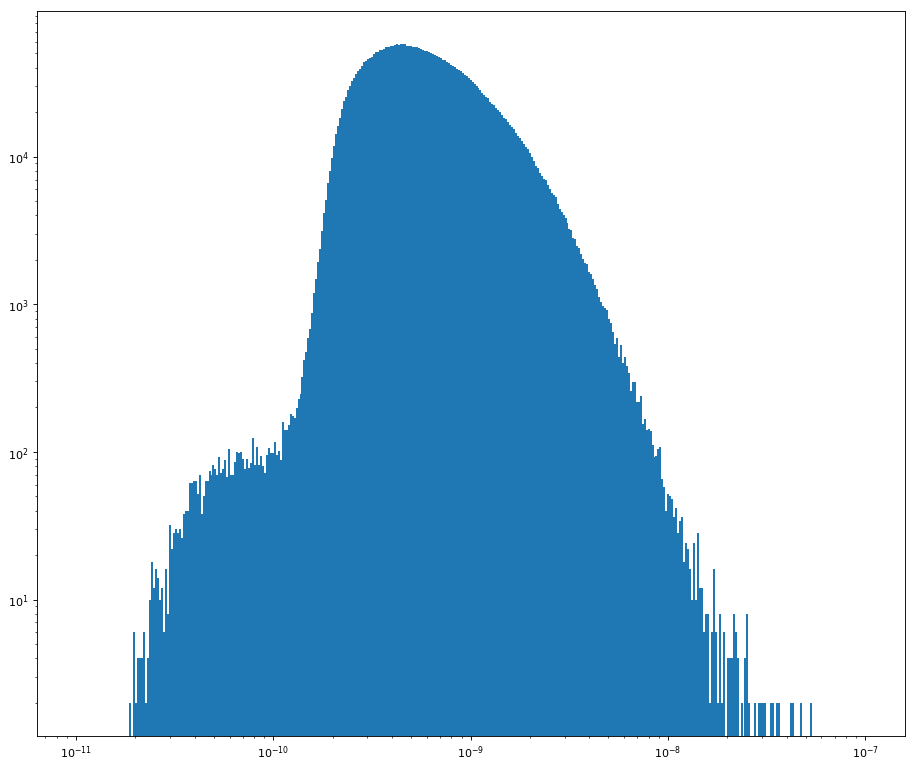

In [23]:
fig=plt.figure(figsize=(14, 12), dpi= 80, facecolor='w', edgecolor='k')
hist = plt.hist(np.squeeze(np.asarray(c)), bins=np.logspace(np.log10(1e-11),np.log10(1e-7), 400), log=True)
plt.gca().set_xscale("log")

SyntaxError: invalid syntax (<ipython-input-35-9c0709bedbbf>, line 1)

In [41]:
def gen(X):
    for i, j in zip(*X.nonzero()):
        yield struct.pack("i", i+1)
        yield struct.pack("i", j+1)
        yield struct.pack("d", X[i,j])
f.write(b''.join(list(gen(X)))

KeyboardInterrupt: 

In [30]:
import numpy as np

X = np.matrix([[1, 2, 0], [2, 0, 0], [0,0,3]])
print(X)

[[1 2 0]
 [2 0 0]
 [0 0 3]]


In [47]:
dinv = np.array(1/X.sum(axis=0))
Dinv = np.diag([1/3, 1/2, 1/3])
D = np.diag([3, 2, 3])
R = Dinv*X

Xnew = 0.5*D*R + 0.5*D*R*R
print(X)
print(Xnew)

[[1 2 0]
 [2 0 0]
 [0 0 3]]
[[1.66666667 1.33333333 0.        ]
 [1.33333333 0.66666667 0.        ]
 [0.         0.         3.        ]]


In [44]:
print(0.5*D*R + 0.5*D*R*R)

[[1.66666667 1.33333333 0.        ]
 [1.33333333 0.66666667 0.        ]
 [0.         0.         3.        ]]


In [48]:
print(D*R*R)

[[2.33333333 0.66666667 0.        ]
 [0.66666667 1.33333333 0.        ]
 [0.         0.         3.        ]]
